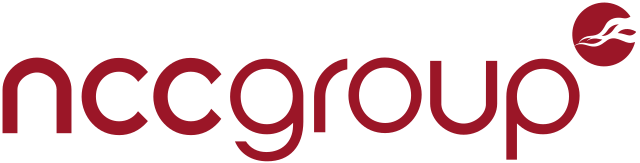

# Machine Learning 104: Breaking AES With Power Side-Channels

Eric Schorn      
Technical Director      
Cryptography Services Practice, NCC Group      
June 15, 2023 

This executable blog post is the fourth in a series related to machine learning and is a fascinating trifecta involving hardened cryptography software, embedded IoT-type hardware, and deep machine learning techniques. While the AES algorithm is designed such that a brute-force secret key guessing attack would likely finish 'sometime near eternity', the power side-channel attack demonstrated here retrieves the 128-bit secret key 'probably closer to lunchtime'. After reviewing the specific attack scenario with its hardware and software elements, we utilize publicly available benchmark profiling data to train a deep machine learning model to support secret key extraction. We then proceed through a methodical process that begins with intermediate model predictions from benchmark attack data and removes the hardening protections to ultimately produce a secret key from approximately 40-100 power traces taken together. While the benchmark-oriented scenario is simplified for clarity, it is very indicative of the difficulty of protecting cryptographic primitives running on embedded hardware from power side-channel attacks.

The approach described here closely follows the paper [Side Channel Analysis against the ANSSI’s protected AES implementation on ARM](https://eprint.iacr.org/2021/592), and utilizes the ASCAD2 public benchmarking data/code available on GitHub at <https://github.com/ANSSI-FR/ASCAD>. The ASCAD2 traces were measured on a MCU running the [Hardened Library for AES-128 encryption/decryption on ARM Cortex M4 Architecture](https://github.com/ANSSI-FR/SecAESSTM32) developed by the French National Cybersecurity Agency (ANSSI). The ASCAD2 dataset was generated because many felt that prior benchmarking datasets had become too easy -- this dataset is extremely difficult to successfully attack. This dataset offers an excellent opportunity for study, exploration and preparation to attack post-quantum algorithms such as Kyber as noted in our [Real World Crypto 2023 summary](https://research.nccgroup.com/2023/05/10/real-world-cryptography-conference-2023-part-i/).

You can run everything for yourself by downloading the data and executing this [.ipynb file](https://github.com/nccgroup/ataraxy/blob/main/ml104/NCCGroup_ML104_blog.ipynb) on any Jupyter-based notebook system. The goal for the code below is to utilize state-of-the-art models while maximizing simplicity, understandability, and accessibility. This is consistent with the three prior posts in the blog series:

* [Machine Learning 101: The Integrity of Image (Mis)Classification?](https://research.nccgroup.com/2022/12/15/machine-learning-101-the-integrity-of-image-misclassification/)
* [Machine Learning 102: Attacking Facial Authentication with Poisoned Data](https://research.nccgroup.com/2023/02/03/machine-learning-102-attacking-facial-authentication-with-poisoned-data/)
* [Machine Learning 103: Exploring LLM Code Generation](https://research.nccgroup.com/2023/04/25/machine-learning-103-exploring-llm-code-generation/)

<br> 

## 1.0 Attack scenario

A simplified scenario with full control over an Internet of Things microcontroller (MCU) is explored. The attacker can repeatedly encrypt chosen plaintext with a given key while capturing power consumption traces. Our goal is to develop and train a machine learning model on a large number of profiling traces to support key extraction. We then test the model's ability to support key extraction on a variable number of additional attack traces that were unseen during training. Note that in a real-world scenario there may be multiple hardware targets, such as one in the lab for controlled profiling with another under attack in the field, and data acquisition may be more challenging.

#### 1.1 Hardware target (MCU)

The target device for this research is an ARM Cortex-M4 based MCU on the [Chip Whisperer](https://www.newae.com/chipwhisperer) board. This board allows users to load software and run repeated encryptions, while capturing a tremendous amount of power trace data. The MCU is underclocked to 4MHz to allow for 25 samples per clock cycle. Each sample is an 8-bit signed integer corresponding to instantaneous power consumption.

#### 1.2 Software target (AES-128)

The ANSSI has developed a [hardened AES library](https://github.com/ANSSI-FR/SecAESSTM32/blob/master/doc/technical-report/technical_analysis.pdf) to protect against side-channel attacks, which exploit the physical properties of a device to reveal secret values. This library performs ECB-mode encryption and decryption in constant time (which itself can be challenging to achieve), and also uses a second-order masking scheme. Each byte `x` of the internal (16-byte) state `s` is replaced with `alpha * x + beta`; where `alpha` is a multiplicative share, and `beta` is an additive share in GF(2<sup>8</sup>) that are constant across rounds.  The internal state starting position and the final results must be adjusted to compensate for the two shares. Additionally, some AES sub-routines are performed in a pseudorandom order, i.e., shuffled. These three additional operations increase the encryption run time to approximately 30-50k clock cycles per block, compared to around 1k clock cycles for a performance optimized version.  Overall, these measures are intended to provide robustness against side-channel attacks and prevent the leakage of sensitive information during the execution of the algorithm.

<br>

## 2.0 Initialization and data preparation

The code starts here by importing standard machine learning frameworks and reporting major version information.

In [1]:
# Clone data at https://github.com/ANSSI-FR/ASCAD
DATA_FILE = "ascadv2-extracted.h5"

import os ; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import absl.logging ; absl.logging.set_verbosity(absl.logging.ERROR)
from random import shuffle
from functools import partial
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import TensorSpec, convert_to_tensor, expand_dims, float32, int8
from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, AveragePooling1D, BatchNormalization, \
    Conv1D, Dense, Flatten, Input, MaxPooling1D, add
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
print(f"Tensorflow version {tf.__version__} with Keras version {tf.keras.__version__}")

Tensorflow version 2.12.0 with Keras version 2.12.0


#### 2.1 Retrieve the data

To train the model for power side-channel analysis, sufficient training data must first be collected from a target device. This process is known as profiling and initially involved capturing 500,000 traces that each contain 2 million raw samples for a total of 500 GB. Given insight into the [AES specification](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.197-upd1.pdf), the source code, and some visual inspection and analysis, two subset windows of potential side-channel leakage were identified. The first window of 5,000 samples is associated with the calculation of the initial/starting `s` states utilizing alpha and beta. The second window of 10,000 samples is associated with the first AES `SubBytes()` (or S-Box substitution) operations. Thus, each of the 500,000 derived training traces contains 15,000 samples that effectively carry the 'signal' and has attached metadata such as the secret key and plaintext. It is important to note that **NO** attack data will be used until after the model has been fully trained in order to ensure valid results. 

#### 2.2 Prepare data

To prepare the data for training, a custom Python generator is implemented and attached to two TensorFlow datasets  suitable for model training and validation. A fixed 90% of the data is allocated to training only, with the remaining 10% held out for validation. This approach will allow us to effectively train the model to predict the sensitive variables in the target device's intermediate computations (with support from the metadata), thereby reducing the AES code's resistance to side-channel attacks.

In [2]:
#!wget https://files.data.gouv.fr/anssi/ascadv2/ascadv2-extracted.h5

In [3]:
# Python generator to yield samples of training data
def generate_data(h5_data, mode):
    traces  = np.array(h5_data['traces'])
    labels  = np.array(h5_data['labels'])
    alpha   = [to_categorical(labels['alpha_mask'], num_classes=256)]
    beta    = [to_categorical(labels['beta_mask'], num_classes=256)]
    sboxes  = [to_categorical(labels['sbox_masked'][:,i], 256) for i in range(16)]
    perms   = [to_categorical(labels['perm_index'][:,i], 16) for i in range(16)]
    targets = alpha + beta + sboxes + perms  # 34 separate targets per trace
    if mode == "train": indices = [i for i in range(int(len(traces)*0.90))]  # 90% train
    else: indices = [int(len(traces)*0.90)+i for i in range(int(len(traces)*0.10))]
    shuffle(indices)
    for index in indices:  # Yield one trace and one [targets] in random order
        yield expand_dims(convert_to_tensor(traces[index]), -1), \
        tuple([convert_to_tensor(targets[i][index]) for i in range(len(targets))])


# Load the data; we are constrained to strictly profiling/training data for now 
data_file = h5py.File(DATA_FILE, "r")
profiling_data = data_file['Profiling_traces']


# Connect Python generators to Tensorflow datasets to feed model training
train_data = Dataset.from_generator(partial(generate_data, profiling_data, "train"), 
    output_signature=((TensorSpec(shape=(15000, 1), dtype=int8), 
     tuple([TensorSpec(shape=(256), dtype=float32) for i in range(18)] +
           [TensorSpec(shape=(16),  dtype=float32) for i in range(16)]
)))).cache().batch(64).prefetch(AUTOTUNE)

valid_data = Dataset.from_generator(partial(generate_data, profiling_data, "valid"), 
    output_signature=((TensorSpec(shape=(15000, 1), dtype=int8), 
     tuple([TensorSpec(shape=(256), dtype=float32) for i in range(18)] +
           [TensorSpec(shape=(16),  dtype=float32) for i in range(16)]
)))).cache().batch(64).prefetch(AUTOTUNE)

As can be seen from the output signature above, the TensorFlow datasets yield individual items consisting of one 15,000-sample trace and 34 target values which are then collected into batches of 64. The 34 target values include an alpha and beta byte, a byte for each of the 16 masked S-Box output predictions, and a nibble for each of the 16 possible shuffling permutations. Note that each of the byte and nibble values are expanded into their one-hot representation of 256 and 16 target classes respectively. Thus, the model predictions will essentially be `2 * 256 + 16 * 256 + 16 * 16 = 4864` values which is relatively large. We will ultimately use the intermediate alpha, beta, and shuffling information to unmask the masked S-Box output predictions. With known plaintext, the unmasked S-Box output predictions are used to extract the key.

#### 2.3 Plot sample

One full trace consisting of 15,000 samples is plotted below along with a zoomed-in subset of the first 1,100 samples. The top rightmost portion of the trace (starting near sample 12,000) shows 10 rounds of `Cipher()` corresponding to Algorithm 1 in Section 5.1 of the AES specification.

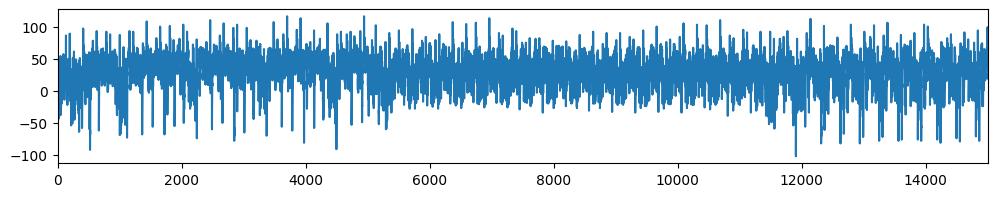

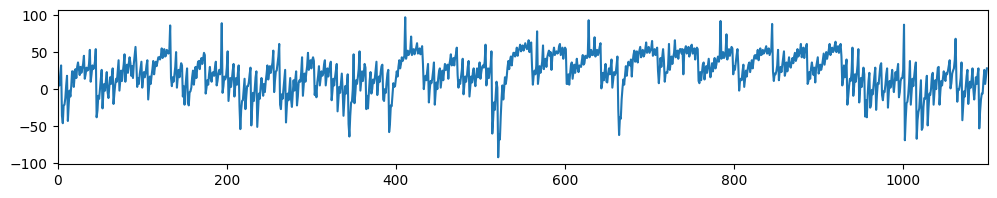

In [4]:
for sample in train_data:
    fig = plt.figure(figsize=(12, 2))
    plt.plot(sample[0][0]); plt.xlim(0, 15000)
    fig = plt.figure(figsize=(12, 2))
    plt.plot(sample[0][0][0:1100]) ; plt.xlim(0, 1100)
    break  # We only want to draw the first trace

<br>

## 3.0 Build and train the model

Now the model will be constructed by first defining a few helper functions that return common model sub-blocks and then utilizing them to build the full deep network model. Once completed, the model is ready for training with the profiling-only traces and intermediate/internal values. When the model is later used for the attack, it consumes the traces and predicts the intermediate/internal values.


#### 3.1 Model sub-blocks

The code below consists of a `resnet_layer()` function that returns an individual layer for subsequent incorporation into a  [Residual Neural Network](https://en.wikipedia.org/wiki/Residual_neural_network) or `resnet`-style block. The returned value is just a parameterized convolutional layer followed by optional batch normalization and activation operations.

The second function `output_block()` below returns an output block reused for each of the model output stages that predict target values. The returned block consists of a fully connected 1,024-element dense layer followed by a normalization operation and finalized by a dense layer with softmax activation. The softmax activation produces one-hot output which can be (loosely) considered probabilities.

In [5]:
# Resnet layer sub-function
def resnet_layer(inputs, num_filters=16, k_size=11, strides=1,
                 activation='relu', batch_norm=True):
    x = inputs
    x = Conv1D(num_filters, kernel_size=k_size, strides=strides, padding='same')(x)
    if batch_norm: x = BatchNormalization()(x)
    if activation is not None: x = Activation(activation)(x)
    return x


# Output block sub-function for alpha, beta, sboxes and perms
def output_block(inputs, name, width):
    x = inputs
    x = Dense(1024, activation='relu', name=f'fc1_{name}')(x)
    x = BatchNormalization()(x)
    x = Dense(width, activation="softmax", name=f'{name}_output')(x)
    return x

#### 3.2 Build overall model

Now the entire model can be built via the `build_model()` function implemented below. As described earlier, the model input consists of a 15,000-sample trace. Nine `resnet` components are stacked on top of each other with their output flattened before arriving at the 34 output blocks. Thus, the deep portion of the network is shared by all output target blocks. As can be seen, certain parameters, such as strides and the number of filters in a `resnet_layer`, are adapted as the network grows. 

In [6]:
# Build the complete 'ResNetSCA' model
def build_model():
    num_filters = 16; strides = 1  # Starting condition
    inputs = Input(shape=(15000,1))
    x = resnet_layer(inputs=inputs)
    for stack in range(9):
        if stack > 0: strides = 2
        y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
        y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
        if stack > 0: x = resnet_layer(inputs=x, num_filters=num_filters, k_size=1,
                                       strides=strides, activation=None, batch_norm=False)
        x = add([x, y])
        x = Activation('relu')(x)
        if (num_filters<256): num_filters *= 2
    x = AveragePooling1D(pool_size=4)(x)
    x = Flatten()(x)
    
    # Total of 34-hot out of 4864 output bits...
    x_alpha = output_block(x, "alpha", 256)
    x_beta = output_block(x, "beta", 256)
    x_sboxes = [output_block(x, f"sbox_{i:02}", 256) for i in range(16)]
    x_perms = [output_block(x, f"perm_{i:02}", 16) for i in range(16)]
    
    return Model(inputs, [x_alpha, x_beta] + x_sboxes + x_perms, name='ResNetSCA')

#### 3.3 Train the model

First, the `plot_history()` helper function is implemented below to plot training results. While it is rather involved and somewhat compressed/messy, there is no magic to be found here.

Next, the model is built and trained. The model consists of 137M trainable parameters, so will fit inside a consumer GPU. The initial learning rate is arguably excessive at `1e-3`, but a callback reduces the learning rate by a factor of 4 whenever forward progress is not made over 2 adjacent epochs (which will happen several times during training). Similarly, the model is checkpointed such that epochs without forward progress are discarded. Thus, the performance plots will show no extended backward trends in validation loss performance. The model was trained for a total of 30 epochs where minor-but-valuable improvements in later epochs appear to primarily involve the S-Box results. 

The plotted performance results suggest that predicting alpha is relatively easy. Predicting the 16 shuffling permutations range from easy to moderately challenging, while predicting beta is definitely moderately challenging (based on the shown validation accuracy). Recall that a random prediction for a one-hot byte would give 0.39% accuracy and a one-hot nibble gives 6.25% accuracy. As such, all but the S-Box output predictions look reasonably good at first glance.

The model's performance on S-Box output predictions is far lower than other values but still about 4X better accuracy than a random choice. As a result, the model will ultimately need to be run on multiple attack traces with predictions aggregated to strengthen the signal while weakening the noise.

137396064 total trainable parameters


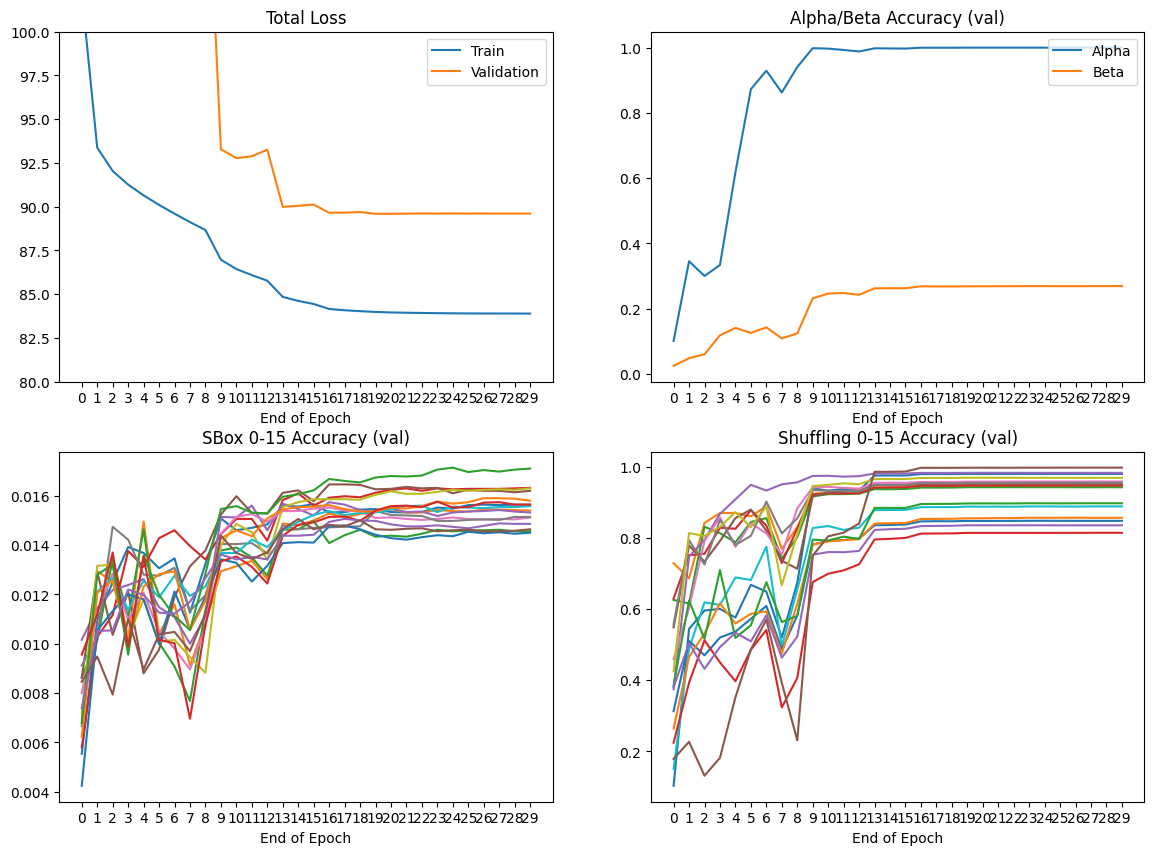

In [7]:
# Plot the training history
def plot_history(hist):
    plt.figure(figsize=(14, 10)); xticks = range(0,len(hist.history["loss"]))
    ax = plt.subplot(2, 2, 1); plt.title("Total Loss")
    plt.plot(hist.history["loss"]); plt.plot(hist.history["val_loss"])
    plt.legend(["Train", "Validation"], loc="upper right"); plt.ylim(80, 100)
    plt.xlabel("End of Epoch"); plt.xticks(xticks)
    ax = plt.subplot(2, 2, 2); plt.title("Alpha/Beta Accuracy (val)")
    plt.plot(hist.history["val_alpha_output_accuracy"])
    plt.plot(hist.history["val_beta_output_accuracy"])
    plt.legend(["Alpha", "Beta"], loc="upper right")
    plt.xlabel("End of Epoch"); plt.xticks(xticks)
    ax = plt.subplot(2, 2, 3); plt.title("SBox 0-15 Accuracy (val)")
    for i in range(16): plt.plot(hist.history[f"val_sbox_{i:02}_output_accuracy"])
    plt.xlabel("End of Epoch"); plt.xticks(xticks)
    ax = plt.subplot(2, 2, 4); plt.title("Shuffling 0-15 Accuracy (val)")
    for i in range(16): plt.plot(hist.history[f"val_perm_{i:02}_output_accuracy"])
    plt.xlabel("End of Epoch"); plt.xticks(xticks)
    plt.show()


# Build and train the model
def train_model():
    model = build_model()
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(1e-3), metrics=['accuracy'])
    callbacks = [ReduceLROnPlateau(factor=0.25, patience=2, verbose=0)]
    callbacks.append(ModelCheckpoint("model_checkpoint", save_best_only=True, verbose=0))
    history = model.fit(train_data, validation_data=valid_data, epochs=30, callbacks=callbacks, verbose=0)
    return history, model


history, model = train_model()
print(f"{np.sum([np.prod(v.shape) for v in model.trainable_variables])} total trainable parameters")
plot_history(history)

<br>

## 4.0 Attack

Now that training is complete, the attack data is retrieved and run through the model to capture predictions spanning all 34 values. The second half of the code below separates out each prediction category so it can be worked with individually. Pay attention to the shrinking `preds_unshuffSboxMulAdd` variable name suffixes as the next few steps remove each masking operation.

In [13]:
# Now that training is complete, we can retrieve the attack data
attack_X = np.array(data_file['Attack_traces/traces'], dtype=np.int8)
attack_meta = data_file['Attack_traces/metadata']


# Make raw predictions from raw attack data
input_data = tf.expand_dims(attack_X[:110, :], -1)
predictions = model.predict(input_data, verbose=0)


# Extract the 34 predictions: alpha, beta, 16x alpha*sbox+beta, and 16x perm
preds_alpha = predictions[0]
preds_beta = predictions[1]
preds_unshuffSboxMulAdd = [predictions[2+i] for i in range(16)]
preds_shuff = [predictions[2+16+i] for i in range(16)]

#### 4.1 Helper functions

Several helper functions are implemented to address the `alpha * x + beta` masking. The first function `addGF256()` performs polynomial addition and the second function `mulGF256()` performs polynomial multiplication modulo the irreducible polynomial x^8 + x^4 + x^3 + x + 1. The S-Box substitution operation is implemented with the help of the `AES_Sbox` lookup table. All of these byte operations are taken directly from the AES specification as noted in the associated code comments.

Finally, a `remove_operation()` function is implemented that is able to effective remove (or unwind) the alpha and beta masking operations. The function uses the supplied operation to produce a set of rearranged indices into the given masked prediction, and then sums the extracted values to effectively remove the mask. This is essentially the [marginalization](https://towardsdatascience.com/probability-concepts-explained-marginalisation-2296846344fc) [operation](https://motion.cs.illinois.edu/RoboticSystems/Probability.html).

In [14]:
# Addition in polynomial GF(2^8)
# See section 4.1 of https://nvlpubs.nist.gov/nistpubs/fips/nist.fips.197.pdf
def addGF256(augend, addend):
    sum = augend ^ addend
    return sum


# Multiplication in GF(2^8) modulo the irreducible polynomial x^8 + x^4 + x^3 + x + 1
# See section 4.2 of https://nvlpubs.nist.gov/nistpubs/fips/nist.fips.197.pdf
def mulGF256(multiplier, multiplicand):  
    irreducible = 0b100011011
    product = 0
    for i in range(8):
        product = product << 1
        if product & 0b100000000: product = addGF256(product, irreducible)
        if multiplicand & 0b010000000: product = addGF256(product, multiplier)
        multiplicand = multiplicand << 1
    return product


# The AES SBox lookup table that we will use to compute the rank
# See Figure 7 of https://nvlpubs.nist.gov/nistpubs/fips/nist.fips.197.pdf
AES_Sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
])


# Given Pr(operation(before, operand) | t) and Pr(operand | t), compute Pr(before | t) 
# E.g., given Pr(Sbox(p^k)*alpha|t) and Pr(alpha), compute Pr(Sbox(p^k))
def remove_operation(before, operand, operation):
    after = np.zeros(before.shape)
    for j in range(256):
        before_rearranged = before[:, [operation(i, j) for i in range(256)]]
        after[:,j] = np.sum(before_rearranged*operand, axis=1)
    return after

#### 4.2 Remove masking

The above `remove_operation()` function is now used to remove the additive beta mask. Note that the input variable name on the far right contains the `Add` suffix, while the resulting variable name does not. These results are then the source of the next step that removes the multiplicative alpha mask. Note that the output variable name no longer contains the `Add` or `Mul` suffixes, but it does suggest there is shuffling to remove next. List comprehensions are utilized to repeat these steps over each of the 16 S-Boxes.

In [15]:
# Remove the GF256 addition of beta
preds_unshuffSboxMul = [remove_operation(x, preds_beta, addGF256) for x in preds_unshuffSboxMulAdd]

# Remove the GF256 mul of alpha
preds_unshuffSbox = [remove_operation(x, preds_alpha, mulGF256) for x in preds_unshuffSboxMul]

#### 4.3 Remove shuffling

Similar to removing the additive and multiplicative masks, now the shuffling gets removed. The `remove_shuff()` function is implemented below that closely follows the earlier removal function from above. This new function is then run on the prior results produced above. The final goal is now in sight now that we have `preds_sbox`.

In [16]:
# Helper funtion to remove shuffling
def remove_shuff(prob_x, prob_shuff, j):
    prob = np.zeros((prob_x.shape[1], prob_x.shape[2]))
    for s in range(prob_x.shape[2]):
        prob_1 = prob_x[:,:,s]
        prob_2 = prob_shuff[:,:,j]
        prob[:,s] = np.sum(prob_1*prob_2, axis=0)
    return prob


# Remove the sbox permutations
preds_sbox = [remove_shuff(np.array(preds_unshuffSbox), np.array(preds_shuff), x) for x in range(16)]

Now that the S-Box output predictions have the alpha and beta masking and the shuffling removed, each S-Box itself can be reversed by using the `AES_Sbox` table implemented earlier. The crucial observation is found in step 3 and the first instance of step 5 in algorithm 1 of section 5.1 `Cipher()` of the [AES specification](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.197-upd1.pdf) -- the key is XORed with the plaintext and then put into the S-Box for substitution. If we know the plaintext and can reverse the S-Box, then the prediction corresponds to the key.

<br>

## 5.0 Results

There are three loops in play below. The outermost loop is iterating though each of the 16 S-Boxes with the goal of examining each byte of the 16-byte key. The middlemost loop is accumulating traces to increase the signal and reduce the noise. The innermost loop calculates a ranking of all key predictions and returns the rank position of the correct key. As the number of traces increases, we hope to see the key ranking decrease -- a rank of 0 means we have the correct secret key byte. Even when the rank of **each** key byte decreases to a small number like 4, it would mean the search space would have collapsed to an upper limit of 4<sup>16</sup> or 2<sup>32</sup>, which is clearly searchable via brute-force. In fact, if the target keys were tried in order of decreasing probability the productive search space would be reduced much further.

The plot shows that as the number of accumulated traces increases, the ranking of each key byte improves. After 100 traces, every byte of the key is clearly ranked at position 0 and thus correctly extracted. Arguably, 40 traces may suffice in this particular instance given some additional searching. Certainly, additional measurement or the remaining attack data is required to fully characterize the strength of our final results. Nonetheless, it is clear that accumulating traces greatly reduces the search space from 'somewhere near eternity' to 'perhaps before lunchtime', which was our goal.

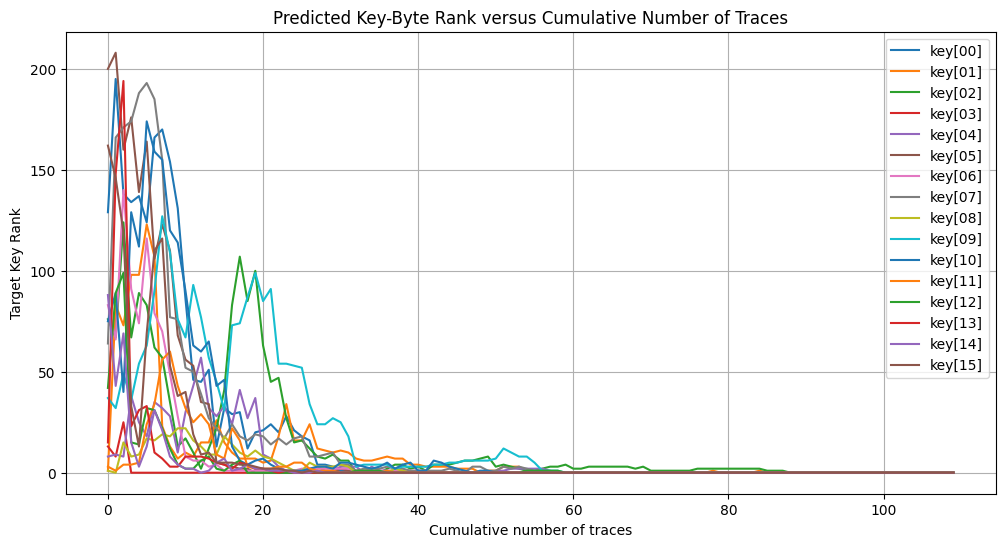

In [17]:
def full_rank(predictions, metadata, target_byte):
    full_rank = []
    key_bytes_prob = np.zeros(256)
    for trace_index in range(predictions.shape[0]): 
        plaintext = metadata[trace_index]['plaintext'][target_byte]
        key = metadata[trace_index]['key'][target_byte]
        for i in range(0, 256):
            prob = predictions[trace_index][AES_Sbox[plaintext ^ key ^ i]]
            key_bytes_prob[i] += np.log(prob + 1e-6)  # Add 1e-6 to avoid -inf
        real_key_rank = key_bytes_prob.argsort()[::-1].argsort()[0]  # Find rank
        full_rank.append(real_key_rank)
    return full_rank


# Plot final key ranking results
fig = plt.figure(figsize=(12, 6))
for target_byte in range(16):
    rank_i = full_rank(preds_sbox[target_byte], attack_meta, target_byte)
    plt.plot(rank_i, label=f"key[{target_byte:02}]")
plt.title('Predicted Key-Byte Rank versus Cumulative Number of Traces')
plt.xlabel('Cumulative number of traces'); plt.ylabel('Target Key Rank')
plt.grid(True); plt.legend(loc='upper right')
plt.show()

<br>

## 6.0 Conclusion

Given the constrained benchmark attack scenario and benchmarking data, a successful power side-channel attack against a hardened AES-128 library was demonstrated. This attack involved removing additive and multiplicative masking as well shuffling. Far less than 100 traces is sufficient to extract the full secret key, and even fewer traces would greatly reduce the productive search space. While hardened libraries are common in smartcard and other high-security applications, most IoT MCU devices use smaller and faster AES libraries that are far less protected from attack. In follow-on posts, we have an opportunity to utilize deep learning techniques on common libraries running on production systems.

The author would like to thank Aleksandar Kircanski, Paul Bottinelli, Eli Sohl and Chris Anley for their detailed review of this blog post. All errors remain with the author.

<br>

---

<br>

**Next steps:** The benchmarking dataset provides ample opportunities for exploration. Several immediate avenues of investigation await the engaged reader:

1. Using the full set of attack data, better characterize the number of traces required to reduce the key search space to a specified threshold. This could include ranking across multiple key bytes (and not just individually).
2. Measure the sensitivity to multiple IoT devices utilized for profiling and attacking.
3. Automate the distillation of raw (2 million sample) traces into even smaller windows. Investigate alignment requirements, which should be minimal given the early convolutional filters.
4. Investigate various optimizers with loss terms driving weight decay.
5. Would increasing the S-Box capacity and or the weight of S-Box loss during training result in significantly better results?